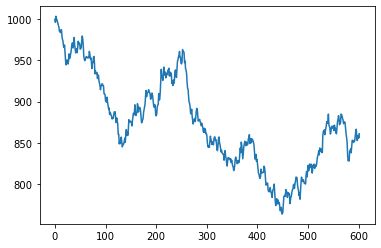

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from DataHandler import DataHandler
from TradingEnv import TradingEnvironment

# dynamics params
X_0 = 100000
q = 5000
F_0 = 1000 # init price
rho = 2.2231
lambda_ = 1/(2*q)
T = 1
N = 600
timestamps = list(range(0, N+1))#[n*T/N for n in range(0,N+1)]

def get_random_walk(scale_param = 5):
    P = F_0
    F = [P]
    for i in range(N+1):
        P += np.random.normal(0, 1)*scale_param
        F.append(P)
    return F
F = get_random_walk()
plt.plot(F)
data = pd.Series(F)

env = TradingEnvironment(data, len(data))
    

In [2]:
state = env.reset()
a = 0
rewards = 0
for i in range(len(data)):
    #print('Step:', env.simulator.step)
    state, reward, info, done = env.step(1)
    rewards += reward
    #print('reward:', info[i])
print(rewards/len(data))
    

-286727647.0683724


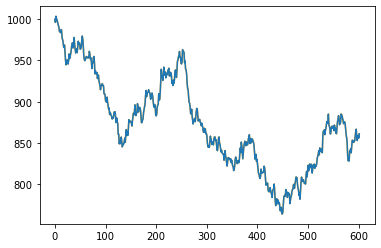

In [3]:
plt.plot(info, color='orange')
plt.plot(data)

In [8]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [10]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        self.action_max = action_max
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return torch.tanh(self.output(x)) * self.action_max
    
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x, a):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(torch.cat((x,a),dim=1)))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [12]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            action = (action + np.random.normal(0., self.exploration_noise, 
                       size=self.action_size)).clip(self.min_action, self.max_action)   
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)

In [47]:
replay_size = 1200 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 1 # update target network every this steps
tau = 0.001

episodes = 30   
discount = 1
batch_size = 32
exploration_noise = 0.45
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01
max_action = X_0
min_action = 1
# create DDPG Agent
agent = DDPGAgent(state_size=3, action_size=1, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

In [50]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 1 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, info, done = env.step(action[0])
        total_reward += reward
        episode_length += 1
        
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale, 1-float(done)))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

Episode: 16 Timestep: 10234 Total reward: -92118307787.1 Episode length: 602.0 Actor Loss: 383.9912 Critic Loss: 1243997.7500
Episode: 17 Timestep: 10836 Total reward: -86326308319.0 Episode length: 602.0 Actor Loss: 327.8316 Critic Loss: 1787287.3750
Episode: 18 Timestep: 11438 Total reward: -101120059255.6 Episode length: 602.0 Actor Loss: 254.8500 Critic Loss: 1067805.3750
Episode: 19 Timestep: 12040 Total reward: -86894656142.1 Episode length: 602.0 Actor Loss: 188.6885 Critic Loss: 1736688.2500
Episode: 20 Timestep: 12642 Total reward: -88630388094.0 Episode length: 602.0 Actor Loss: 133.4109 Critic Loss: 1495806.2500
Episode: 21 Timestep: 13244 Total reward: -87610593432188640.0 Episode length: 602.0 Actor Loss: 97.0165 Critic Loss: 1320878.6250
Episode: 22 Timestep: 13846 Total reward: -110511340771.4 Episode length: 602.0 Actor Loss: 68.4017 Critic Loss: 955058225152.0000
Episode: 23 Timestep: 14448 Total reward: -92641997963.7 Episode length: 602.0 Actor Loss: 38.8631 Critic L

In [6]:
import numpy as np
from agent import Agent

from collections import deque

# Create simulation environment
episodes = 12
# Initialize Feed-forward DNNs for Actor and Critic models. 
#agent = Agent(state_size=3, action_size=1,random_seed = 1234)
#agent.reset()
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env.reset()

    # set the environment to make transactions
    avg_rewards = 0
    for i in range(len(data)):
      
        # Predict the best action for the current state.
        action = float(agent.act(cur_state, add_noise = True))
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward, info, done = env.step(action*X_0)
        #print('reward', reward)
        avg_rewards += reward
        #print(new_state)
        # current state, action, reward, new state are stored in the experience replay 
        agent.step(cur_state, action, reward, new_state, done)
        # roll over new state
        cur_state = new_state
        if done == True:
            print('Episode', episode, '|| Avg reward:', avg_rewards/len(data))
            break

Episode 0 || Avg reward: -165298323189095.56
Episode 1 || Avg reward: -117503182095563.56
Episode 2 || Avg reward: -278651719274123.84
Episode 3 || Avg reward: -277466318175086.34
Episode 4 || Avg reward: -178264398416785.34
Episode 5 || Avg reward: -150916191261052.53
Episode 6 || Avg reward: -185524717085877.28
Episode 7 || Avg reward: -200585160203659.62
Episode 8 || Avg reward: -141246284716939.8
Episode 9 || Avg reward: -208897749719436.78
Episode 10 || Avg reward: -145949369048714.6
Episode 11 || Avg reward: -201919811402885.22


In [52]:
print(sum(env.simulator.actions))

107875.3148072959


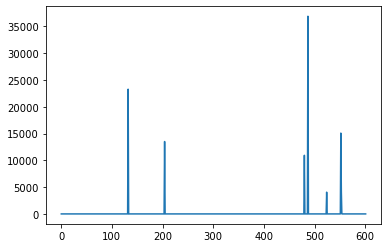

In [51]:
#plt.plot(env2.simulator.actions)
plt.plot(env.simulator.actions)

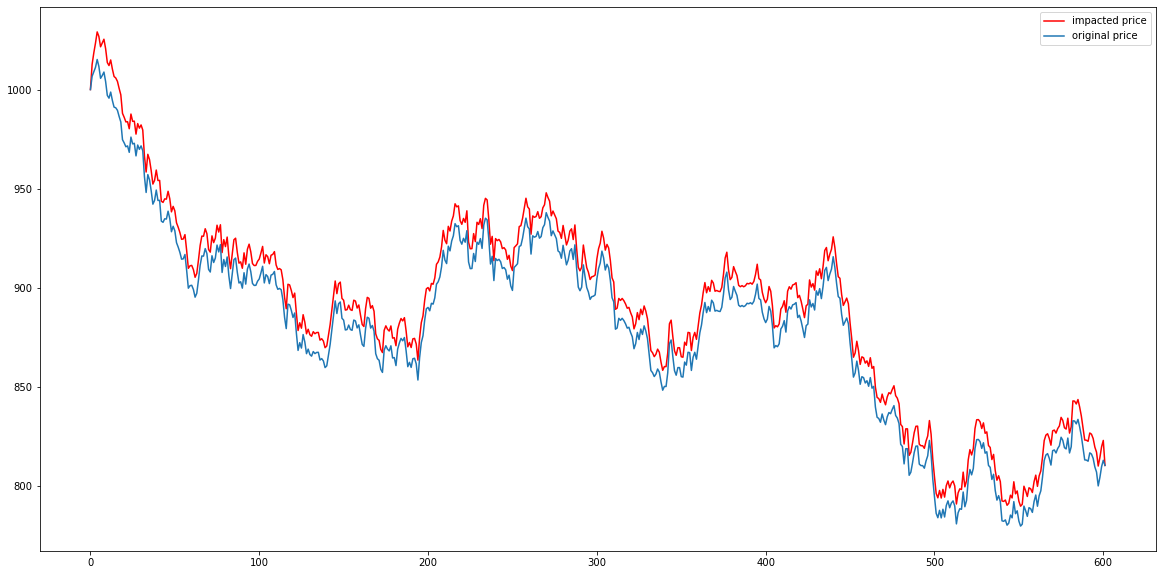

In [6]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price')
plt.plot(data, label = 'original price')
plt.legend()

In [7]:
env2 = TradingEnvironment(data, len(data))

state = env2.reset()
a = 0
for i in range(len(data)):
    if i == 0 or i == len(data)-2:
        a = X_0/(rho*T + 2)
        state, reward, info, done = env2.step(a)
    else:
        a = rho*X_0/(rho*T+2)/(len(data)-3)
        state, reward, info, done = env2.step(a)
    

In [9]:
print('Average cost:', np.mean(env2.simulator.strategy_costs))
print('Total cost:', np.sum(env2.simulator.strategy_costs))

print('Average cost (RL):', np.mean(env.simulator.strategy_costs))
print('Total cost (RL):', np.sum(env.simulator.strategy_costs))

print('diff costs:', np.sum(env.simulator.strategy_costs) - np.sum(env2.simulator.strategy_costs))

Average cost: -149198.2535804223
Total cost: -89817348.65541422
Average cost (RL): -168640.15195022797
Total cost (RL): -101521371.47403724
diff costs: -11704022.818623021


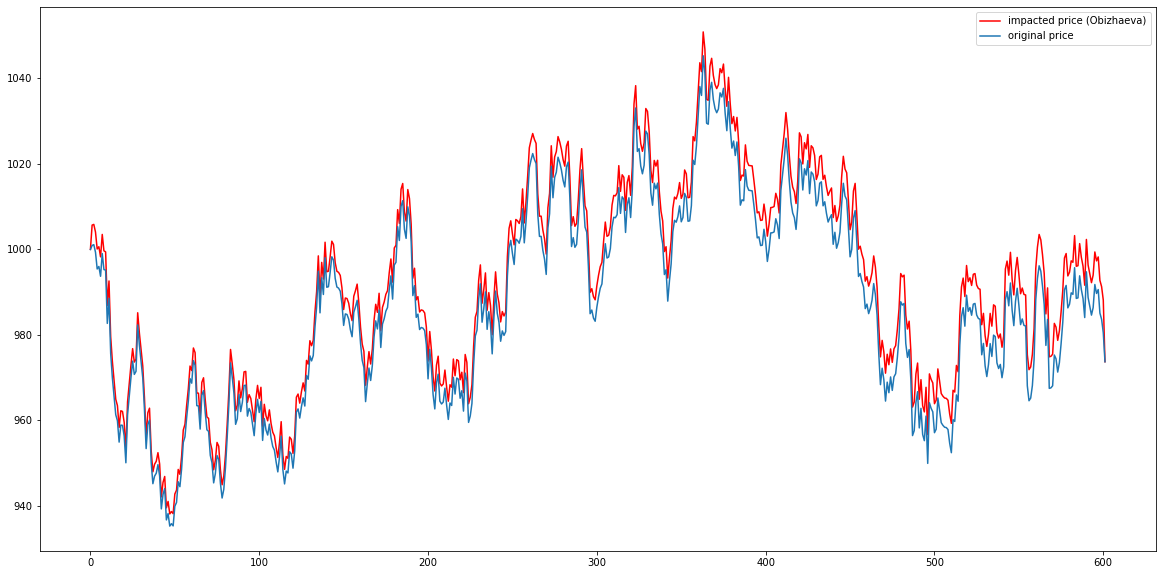

In [41]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price (Obizhaeva)')
plt.plot(data, label = 'original price')
plt.legend()